In [156]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD

tickers = ["AAPL", "MSFT", "NVDA", "JPM", "XOM", "TSLA"]
raw_data = yf.download(tickers, period="2y", interval="1d", auto_adjust=True)

print(raw_data.head())

[*********************100%***********************]  6 of 6 completed

Price            Close                                                 \
Ticker            AAPL         JPM        MSFT       NVDA        TSLA   
Date                                                                    
2023-06-28  187.373962  131.951355  330.707672  41.091713  256.239990   
2023-06-29  187.710587  136.559509  329.919830  40.796894  257.500000   
2023-06-30  192.047165  138.473251  335.325806  42.275978  261.769989   
2023-07-03  190.552155  139.587204  332.814850  42.386909  279.820007   
2023-07-05  189.433334  138.657318  332.972412  42.290974  282.480011   

Price                         High                                     ...  \
Ticker             XOM        AAPL         JPM        MSFT       NVDA  ...   
Date                                                                   ...   
2023-06-28   98.384216  188.017513  132.541666  332.805064  41.819266  ...   
2023-06-29   99.597687  188.185839  136.683287  330.963598  41.574416  ...   
2023-06-30  100.111069  1

In [157]:
def compute_avwap(price, volume, window=20):
    cum_vol_price = (price * volume).rolling(window=window).sum()
    cum_volume = volume.rolling(window=window).sum()
    return cum_vol_price / cum_volume

def compute_r2(price, window=20):
    r2 = []
    for i in range(len(price)):
        if i < window:
            r2.append(np.nan)
        else:
            y = price.iloc[i - window:i].values
            x = np.arange(window)
            slope, intercept = np.polyfit(x, y, 1)
            y_hat = slope * x + intercept
            ss_res = np.sum((y - y_hat) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2_val = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
            r2.append(r2_val)
    return pd.Series(r2, index=price.index)

In [158]:
trade_logs = []


for ticker in raw_data.columns.levels[1]:
    df = raw_data.xs(ticker, level=1, axis=1).copy()

    df["AVWAP_5"] = compute_avwap(df["Close"], df["Volume"], window=5)
    df["R2_5"] = compute_r2(df["AVWAP_5"], window=5)

    df["AVWAP_10"] = compute_avwap(df["Close"], df["Volume"], window=10)
    df["R2_10"] = compute_r2(df["AVWAP_10"], window=10)

    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    macd = MACD(close=df["Close"])
    df["MACD_Diff"] = macd.macd_diff()

    df["Price_to_AVWAP_5"] = df["Close"] / df["AVWAP_5"]
    df["Price_to_AVWAP_10"] = df["Close"] / df["AVWAP_10"]

    # Entry signal: fast AVWAP + fast R2
    df["Signal"] = (df["Close"] > df["AVWAP_5"]) & (df["R2_5"] > 0.8)

    # 5-day forward return as trade outcome
    df["Future_Return"] = df["Close"].shift(-5) / df["Close"] - 1
    df["Label"] = (df["Future_Return"] > 0).astype(int)

    # Log triggered trades
    triggered = df[df["Signal"]].dropna(subset=[
        "R2_5", "R2_10", "RSI", "MACD_Diff",
        "Price_to_AVWAP_5", "Price_to_AVWAP_10", "Label"
    ])

    for idx, row in triggered.iterrows():
        trade_logs.append({
            "Date": idx,
            "Ticker": ticker,
            "R2_5": row["R2_5"],
            "R2_10": row["R2_10"],
            "RSI": row["RSI"],
            "MACD_Diff": row["MACD_Diff"],
            "Price_to_AVWAP_5": row["Price_to_AVWAP_5"],
            "Price_to_AVWAP_10": row["Price_to_AVWAP_10"],
            "Label": row["Label"]
        })


In [159]:
trade_log_df = pd.DataFrame(trade_logs)

print(trade_log_df.head())

        Date Ticker      R2_5     R2_10        RSI  MACD_Diff  \
0 2023-08-21   AAPL  0.957969  0.998339  31.050350  -0.878238   
1 2023-08-22   AAPL  0.978898  0.994025  35.580332  -0.555152   
2 2023-08-23   AAPL  0.924750  0.981802  46.227962  -0.045561   
3 2023-08-28   AAPL  0.932599  0.784117  46.505280   0.464159   
4 2023-08-29   AAPL  0.996670  0.651192  53.852810   0.875265   

   Price_to_AVWAP_5  Price_to_AVWAP_10  Label  
0          1.002148           0.993308      1  
1          1.010340           1.002948      1  
2          1.027136           1.023170      1  
3          1.008363           1.017914      1  
4          1.022549           1.036079      0  


In [ ]:
import xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

X = trade_log_df[["R2_5", "R2_10", "RSI", "MACD_Diff", "Price_to_AVWAP_5", "Price_to_AVWAP_10"]]
y = trade_log_df["Label"]

# Train / Calib+Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)

# Calib / Test split
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)


base_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

base_model.fit(
    X_train, y_train,
    eval_set=[(X_calib, y_calib)],
    verbose=False
)

calibrated_model = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_calib, y_calib)

X_all = trade_log_df[["R2_5", "R2_10", "RSI", "MACD_Diff", "Price_to_AVWAP_5", "Price_to_AVWAP_10"]]
trade_log_df["prob"] = calibrated_model.predict_proba(X_all)[:, 1]



/Users/robp/scm/personal/github.com/robpickerill/moment2/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning:

[14:26:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/Users/robp/scm/personal/github.com/robpickerill/moment2/.venv/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



In [170]:
from sklearn.metrics import classification_report

y_pred = calibrated_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       138
           1       0.65      0.76      0.70       190

    accuracy                           0.63       328
   macro avg       0.61      0.60      0.60       328
weighted avg       0.62      0.63      0.62       328



In [174]:
from sklearn.metrics import roc_auc_score

y_score = calibrated_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_score)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.6879


In [171]:
df_all_tickers = {}

# Map of (Date, Ticker) → prob
prob_lookup = trade_log_df.set_index(["Date", "Ticker"])["prob"]

for ticker in tickers:
    sub_df = raw_data.xs(ticker, level=1, axis=1).copy()

    # Feature engineering
    sub_df["AVWAP_5"] = compute_avwap(sub_df["Close"], sub_df["Volume"], window=5)
    sub_df["R2_5"] = compute_r2(sub_df["AVWAP_5"], window=5)

    # --- FIXED ---
    r2_thresh = sub_df["R2_5"].quantile(0.6)  # ticker-specific
    sub_df["Signal"] = (sub_df["Close"] > sub_df["AVWAP_5"]) & (sub_df["R2_5"] > r2_thresh)

    sub_df["Future_Return"] = sub_df["Close"].shift(-5) / sub_df["Close"] - 1
    sub_df["Label"] = (sub_df["Future_Return"] > 0).astype(int)

    # Inject meta-model probabilities
    sub_df["prob"] = sub_df.index.map(lambda d: prob_lookup.get((d, ticker), np.nan))

    # Store result
    df_all_tickers[ticker] = sub_df


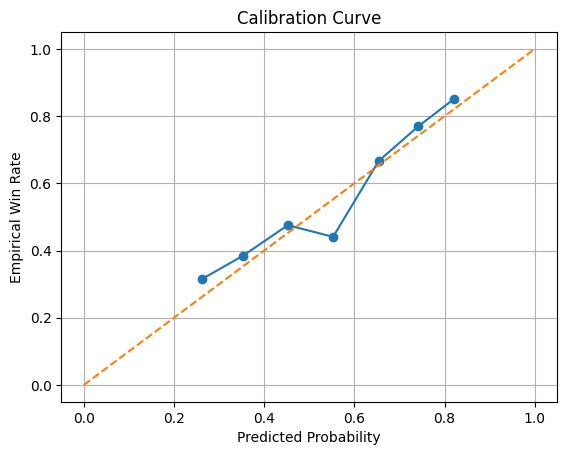

In [175]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_score, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Win Rate")
plt.title("Calibration Curve")
plt.grid(True)
plt.show()

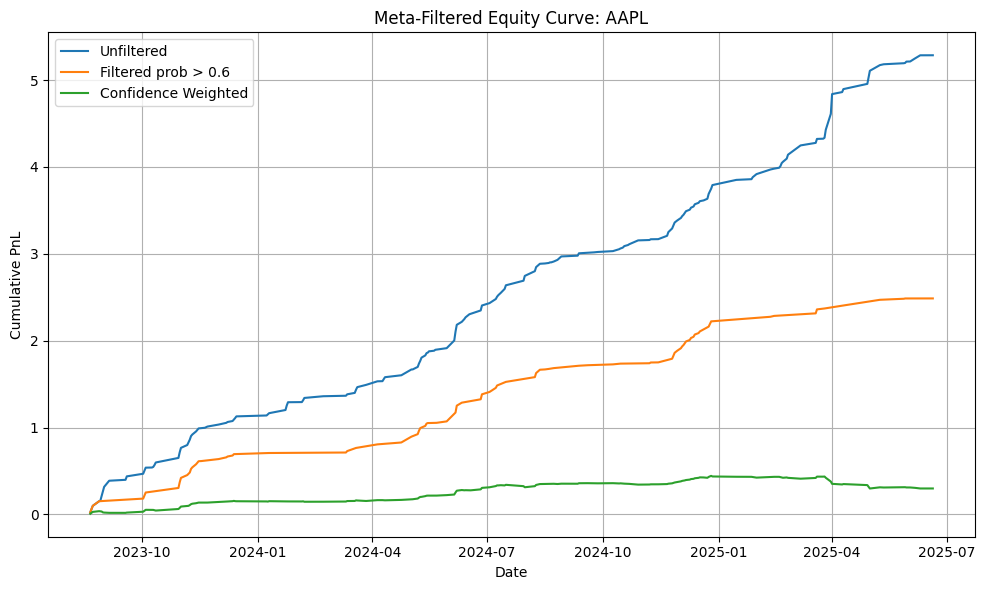

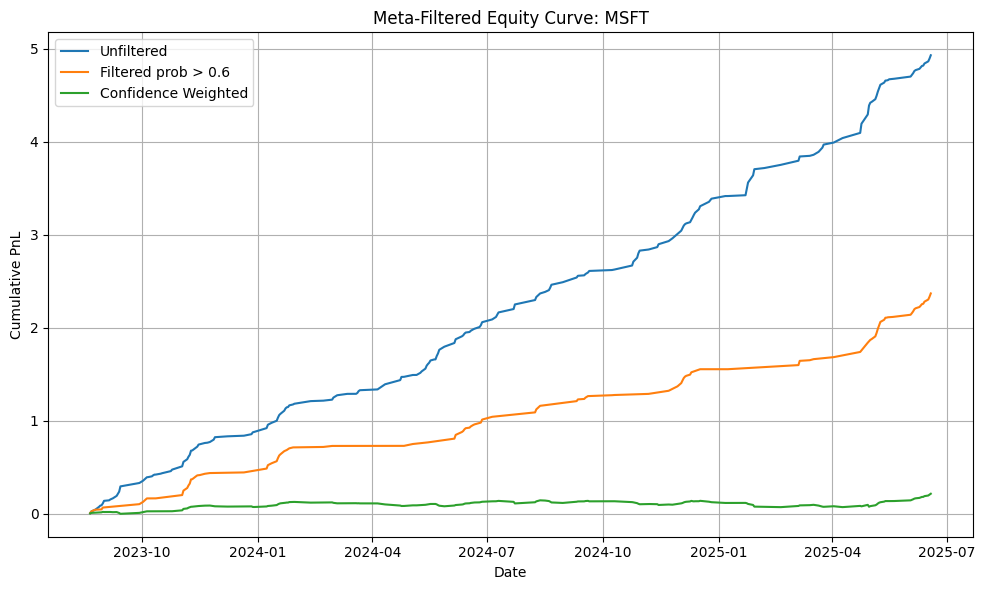

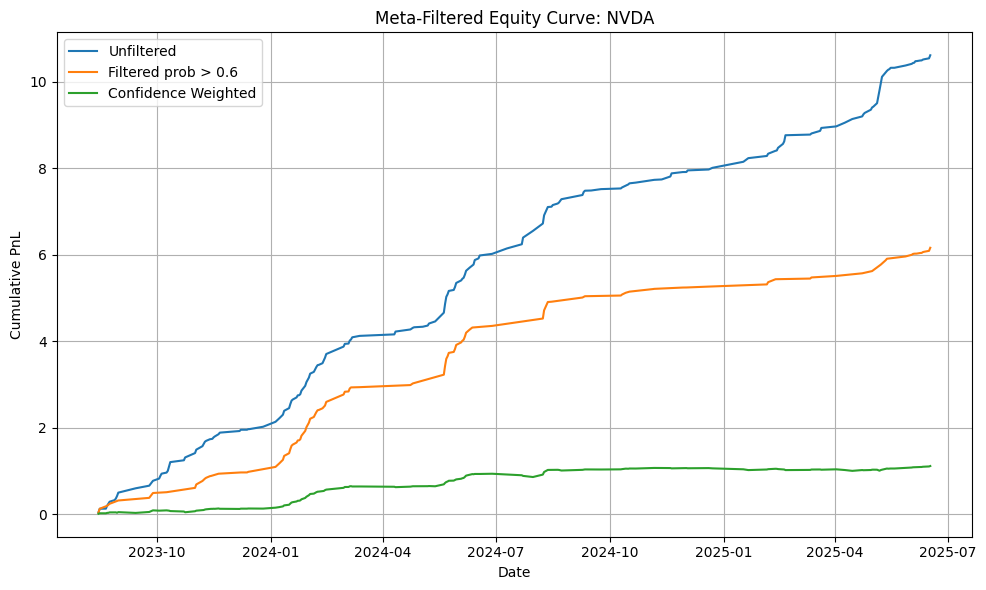

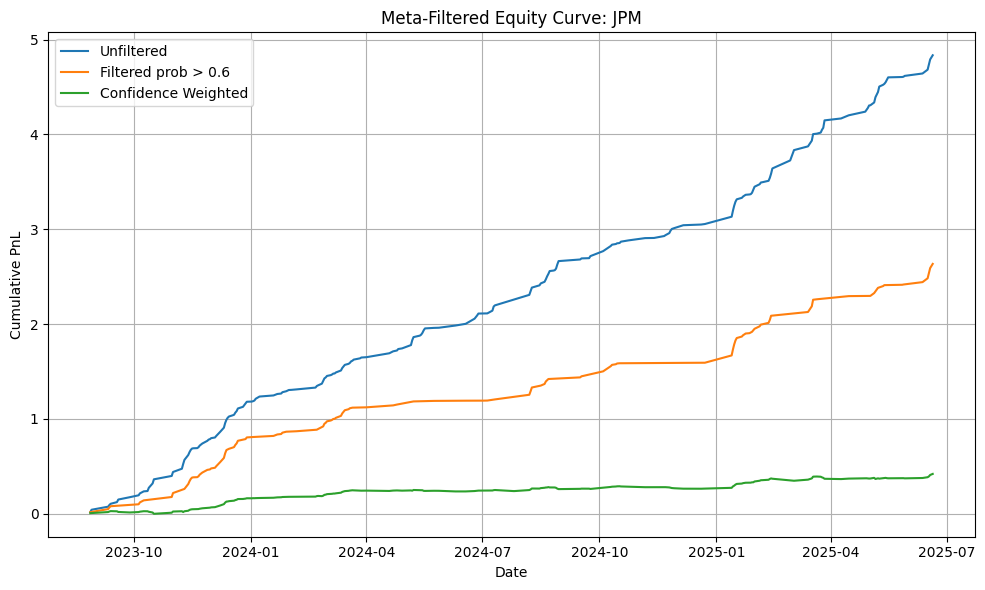

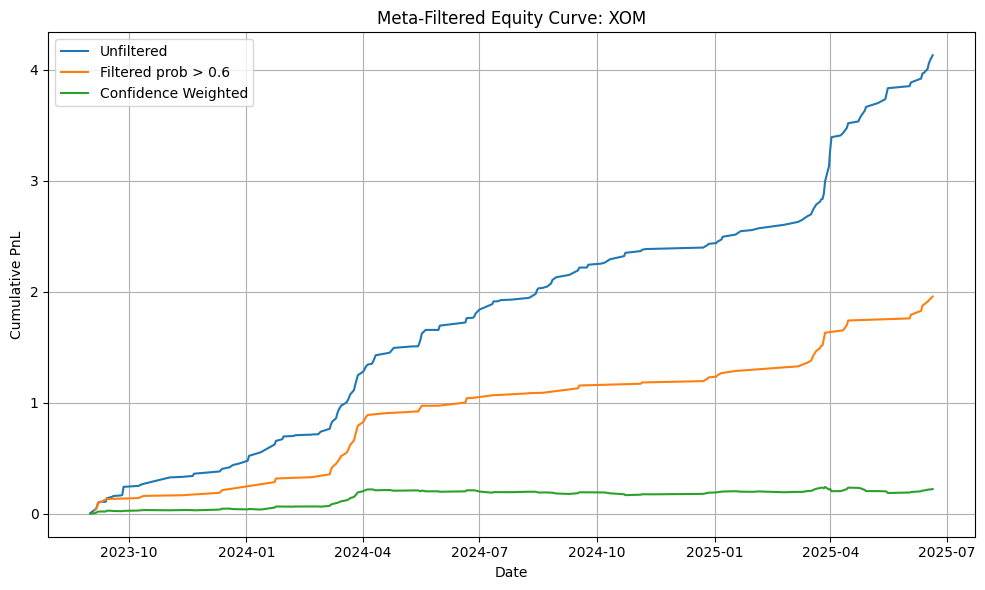

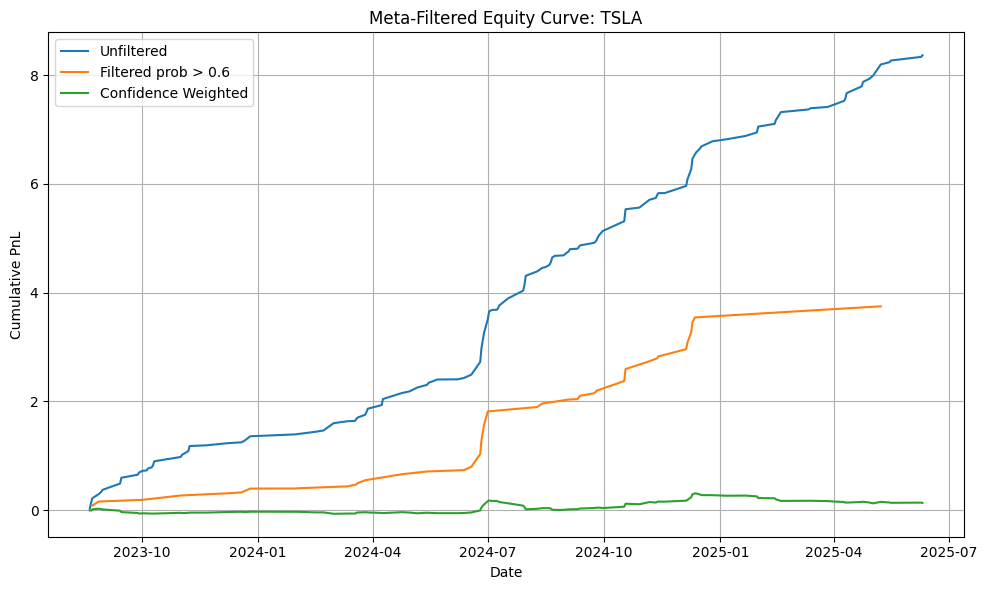

In [176]:
for ticker, df in df_all_tickers.items():
    df = df.dropna(subset=["prob", "Label"]).copy()
    df = df.sort_index()

    df["PnL"] = df["Future_Return"] * (2 * df["Label"] - 1)
    df["Equity_All"] = df["PnL"].cumsum()

    filtered = df[df["prob"] > 0.6].copy()
    filtered["Equity_Filtered"] = filtered["PnL"].cumsum()

    df["Weight"] = df["prob"] - 0.5
    df["PnL_Weighted"] = df["PnL"] * df["Weight"]
    df["Equity_Weighted"] = df["PnL_Weighted"].cumsum()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df["Equity_All"], label="Unfiltered")
    plt.plot(filtered.index, filtered["Equity_Filtered"], label="Filtered prob > 0.6")
    plt.plot(df.index, df["Equity_Weighted"], label="Confidence Weighted")
    plt.title(f"Meta-Filtered Equity Curve: {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import vectorbt as vbt
import pandas as pd
import numpy as np

portfolios = {}
stats = {}

for ticker, sub_df in df_all_tickers.items():
    # Entry signals
    long_entries = (sub_df["Signal"]) & (sub_df["prob"] > 0.6)
    short_entries = (sub_df["Signal"]) & (sub_df["prob"] < 0.4)

    # Exit both long and short after 5 days
    long_exits = long_entries.shift(5).fillna(False)
    short_exits = short_entries.shift(5).fillna(False)

    # Size based on probability (positive for long, negative for short)
    size_long = np.exp((sub_df["prob"] - 0.5) * 5)
    size_short = np.exp((0.5 - sub_df["prob"]) * 5)

    # Combine into one size series
    size = pd.Series(0.0, index=sub_df.index)
    size[long_entries] = size_long[long_entries]
    size[short_entries] = size_short[short_entries]

    price = sub_df["Close"]

    pf = vbt.Portfolio.from_signals(
        close=price,
        entries=long_entries,
        exits=long_exits,
        short_entries=short_entries,
        short_exits=short_exits,
        size=size,
        fees=0.001,
        slippage=0.001,
        init_cash=10_000,
        accumulate=True,
        freq='1D'
    )
    portfolios[ticker] = pf
    stats[ticker] = pf.stats()

stats_df = pd.concat(stats, axis=1)

/var/folders/rj/yzf6d91109g04bw78952kx4r0000gn/T/ipykernel_77078/4275010172.py:14: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/rj/yzf6d91109g04bw78952kx4r0000gn/T/ipykernel_77078/4275010172.py:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



ValueError: Negative size is not allowed. You must express direction using signals.

In [ ]:
for ticker in portfolios:
    print(f"Stats for {ticker}:")
    print(portfolios[ticker].plot().show())

Stats for AAPL:


None
Stats for MSFT:


None
Stats for NVDA:


None
Stats for JPM:


None
Stats for XOM:


None
Stats for TSLA:


None


In [ ]:
for ticker in portfolios:
    print(f"Stats for {ticker}:")
    print(portfolios[ticker].stats())
    print("\n")

Stats for AAPL:
Start                         2023-06-28 00:00:00
End                           2025-06-27 00:00:00
Period                          502 days 00:00:00
Start Value                               10000.0
End Value                            10039.045639
Total Return [%]                         0.390456
Benchmark Return [%]                     7.314822
Max Gross Exposure [%]                  32.049508
Total Fees Paid                          4.377872
Max Drawdown [%]                        10.948063
Max Drawdown Duration           124 days 00:00:00
Total Trades                                   10
Total Closed Trades                             9
Total Open Trades                               1
Open Trade PnL                         -24.835154
Win Rate [%]                                100.0
Best Trade [%]                          27.703778
Worst Trade [%]                          1.673689
Avg Winning Trade [%]                   11.419579
Avg Losing Trade [%]              